Using device: cuda
Starting training...
Epoch 1/21, Loss: 3.0818
Validation Accuracy: 17.80%, Macro F1-Score: 0.1153
Epoch 2/21, Loss: 2.2746
Validation Accuracy: 32.60%, Macro F1-Score: 0.2693
Epoch 3/21, Loss: 1.9799
Validation Accuracy: 40.80%, Macro F1-Score: 0.3722
Epoch 4/21, Loss: 1.7698
Validation Accuracy: 43.00%, Macro F1-Score: 0.3906
Epoch 5/21, Loss: 1.5682
Validation Accuracy: 45.40%, Macro F1-Score: 0.4136
Epoch 6/21, Loss: 1.4402
Validation Accuracy: 52.00%, Macro F1-Score: 0.4902
Epoch 7/21, Loss: 1.3238
Validation Accuracy: 56.00%, Macro F1-Score: 0.5307
Epoch 8/21, Loss: 1.1942
Validation Accuracy: 52.00%, Macro F1-Score: 0.5013
Epoch 9/21, Loss: 1.1342
Validation Accuracy: 58.80%, Macro F1-Score: 0.5625
Epoch 10/21, Loss: 1.0470
Validation Accuracy: 57.80%, Macro F1-Score: 0.5557
Epoch 11/21, Loss: 0.9732
Validation Accuracy: 56.80%, Macro F1-Score: 0.5420
Epoch 12/21, Loss: 0.9217
Validation Accuracy: 62.60%, Macro F1-Score: 0.6070
Epoch 13/21, Loss: 0.8037
Validat

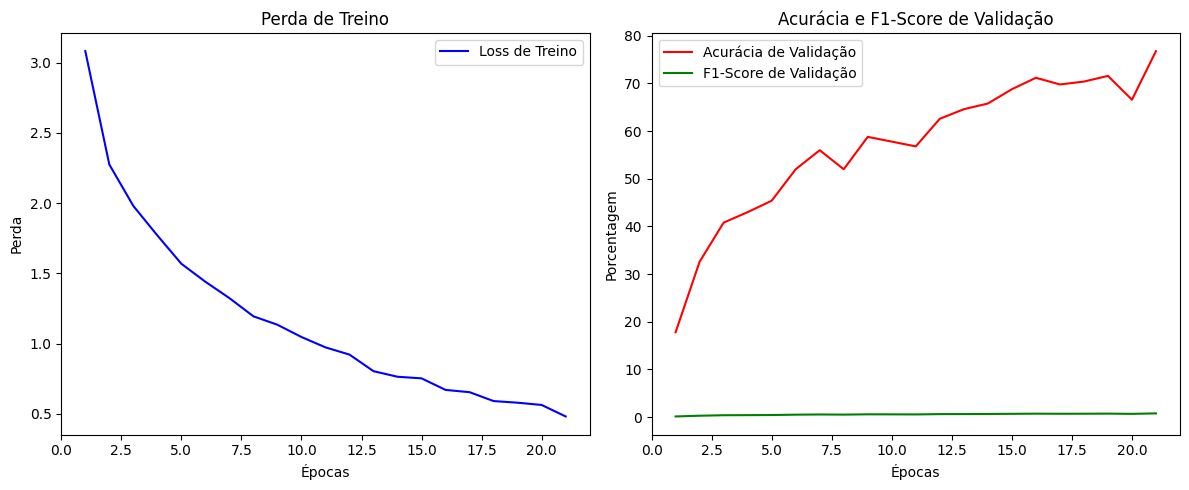

Testing model on test dataset...
Validation Accuracy: 74.60%, Macro F1-Score: 0.7266


In [2]:
import torch
import torchvision
import numpy as np
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset, Dataset
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import os

# Verificar se GPU está disponível
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Classe para manipulação dos dados e treinamento do modelo
class ImageClassifier:
    def __init__(self, num_classes, batch_size=32, lr=0.001, epochs=10):
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.lr = lr
        self.epochs = epochs
        self.model = self.create_model()
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.class_mapping = None
        self.train_loader = None
        self.val_loader = None
        self.test_loader = None

    # Criação do modelo ResNet18
    def create_model(self):
        model = models.resnet18()
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(
            #nn.Dropout(0.5),
            nn.Linear(num_ftrs, self.num_classes)
        )
        return model.to(device)

    # Função para filtrar as classes desejadas
    @staticmethod
    def filter_classes(dataset, selected_classes):
        indices = [idx for idx, (_, label) in enumerate(dataset) if label in selected_classes]
        return Subset(dataset, indices)

    # Classe customizada para mapear os rótulos das classes
    class MappedDataset(Dataset):
        def __init__(self, subset, class_mapping):
            self.subset = subset
            self.class_mapping = class_mapping

        def __len__(self):
            return len(self.subset)

        def __getitem__(self, idx):
            img, label = self.subset[idx]
            label = self.class_mapping.get(label, -1)
            return img, label

    # Função para preparar os dados e criar DataLoader
    def prepare_data(self, data_transform, train_dataset, val_dataset, test_dataset, selected_classes):
        # Mapear classes para [0, 49]
        self.class_mapping = {original: new for new, original in enumerate(selected_classes)}

        # Filtragem e mapeamento dos datasets
        train_subset = self.filter_classes(train_dataset, selected_classes)
        val_subset = self.filter_classes(val_dataset, selected_classes)
        test_subset = self.filter_classes(test_dataset, selected_classes)

        train_mapped = self.MappedDataset(train_subset, self.class_mapping)
        val_mapped = self.MappedDataset(val_subset, self.class_mapping)
        test_mapped = self.MappedDataset(test_subset, self.class_mapping)

        # DataLoaders
        self.train_loader = DataLoader(train_mapped, batch_size=self.batch_size, shuffle=True)
        self.val_loader = DataLoader(val_mapped, batch_size=self.batch_size, shuffle=False)
        self.test_loader = DataLoader(test_mapped, batch_size=self.batch_size, shuffle=False)

    # Função de treino
    def train(self):
        print("Starting training...")
        train_losses = []
        val_accuracies = []
        val_f1_scores = []

        for epoch in range(self.epochs):
            self.model.train()
            running_loss = 0.0
            for inputs, labels in self.train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(self.train_loader.dataset)
            train_losses.append(epoch_loss)
            print(f'Epoch {epoch + 1}/{self.epochs}, Loss: {epoch_loss:.4f}')

            # Validação após cada época
            val_accuracy, val_f1 = self.validate(self.val_loader)
            val_accuracies.append(val_accuracy)
            val_f1_scores.append(val_f1)

        print("Training complete.")
        return train_losses, val_accuracies, val_f1_scores

    # Função de validação
    def validate(self, loader):
        self.model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []

        with torch.no_grad():
            for inputs, labels in loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

        accuracy = accuracy_score(all_labels, all_predictions) * 100
        f1 = f1_score(all_labels, all_predictions, average='macro')
        print(f'Validation Accuracy: {accuracy:.2f}%, Macro F1-Score: {f1:.4f}')
        return accuracy, f1

    # Função para testar o modelo com o conjunto de teste
    def test(self):
        print("Testing model on test dataset...")
        return self.validate(self.test_loader)

# Uso da classe ImageClassifier para treino, validação e teste

# Parâmetros
selected_classes = np.array([7, 18, 64, 14, 8, 47, 94, 84, 30, 74, 27, 70, 33, 1, 28, 95, 32,
                             72, 77, 60, 55, 79, 11, 54, 59, 29, 51, 43, 71, 5, 92, 53, 34,
                             2, 48, 36, 9, 39, 42, 15, 17, 86, 45, 93, 62, 49, 46, 82, 68, 21])

data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomAffine(degrees=30, shear=20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
def plot_curves(train_losses, val_accuracies, val_f1_scores):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot da curva de perda de treino
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Loss de Treino')
    plt.title('Perda de Treino')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    # Plot da curva de acurácia de validação
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, 'r', label='Acurácia de Validação')
    plt.plot(epochs, val_f1_scores, 'g', label='F1-Score de Validação')
    plt.title('Acurácia e F1-Score de Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Porcentagem')
    plt.legend()

    # Exibir os gráficos
    plt.tight_layout()
    plt.show()
# Carregamento dos datasets
train_dataset = datasets.Flowers102(root=r'E:\Dataset_torchvision', split='test', download=True, transform=data_transform)
val_dataset = datasets.Flowers102(root=r'E:\Dataset_torchvision', split='val', download=True, transform=data_transform)
test_dataset = datasets.Flowers102(root=r'E:\Dataset_torchvision', split='train', download=True, transform=data_transform)
num_classes=50
batch_size=32
lr=0.0001
epochs=21

# Inicializar a classe
classifier = ImageClassifier(num_classes=num_classes, batch_size=batch_size, lr=lr, epochs=epochs)
#classifier.model.load_state_dict(torch.load(r"C:\Users\fabri\Desktop\UFES\ML\data" + os.sep + 'train_5_epoch_21.pth', weights_only=True))
# Preparar os dados
classifier.prepare_data(data_transform, train_dataset, val_dataset, test_dataset, selected_classes)

# Treinamento e validação
train_losses, val_accuracies, val_f1_scores = classifier.train()
plot_curves(train_losses,val_accuracies,val_f1_scores)
# Teste do modelo no conjunto de teste
test_accuracy, test_f1 = classifier.test()
import os
modelo_criado = f'train_1_epoch_{epochs}_lr_{str(lr)}_drop.pth'
torch.save(classifier.model.state_dict(), r"C:\Users\fabri\Desktop\UFES\ML\data" + os.sep + modelo_criado)

Using device: cuda
Starting training...
Epoch 1/21, Loss: 0.5201
Validation Accuracy: 75.00%, Macro F1-Score: 0.7482
Epoch 2/21, Loss: 0.4587
Validation Accuracy: 72.00%, Macro F1-Score: 0.7213
Epoch 3/21, Loss: 0.4303
Validation Accuracy: 71.60%, Macro F1-Score: 0.7126
Epoch 4/21, Loss: 0.4071
Validation Accuracy: 76.60%, Macro F1-Score: 0.7547
Epoch 5/21, Loss: 0.4069
Validation Accuracy: 71.60%, Macro F1-Score: 0.7076
Epoch 6/21, Loss: 0.3806
Validation Accuracy: 77.60%, Macro F1-Score: 0.7739
Epoch 7/21, Loss: 0.3589
Validation Accuracy: 78.60%, Macro F1-Score: 0.7788
Epoch 8/21, Loss: 0.3313
Validation Accuracy: 75.00%, Macro F1-Score: 0.7384
Epoch 9/21, Loss: 0.3125
Validation Accuracy: 79.00%, Macro F1-Score: 0.7858
Epoch 10/21, Loss: 0.2959
Validation Accuracy: 73.20%, Macro F1-Score: 0.7296
Epoch 11/21, Loss: 0.2763
Validation Accuracy: 79.40%, Macro F1-Score: 0.7942
Epoch 12/21, Loss: 0.2714
Validation Accuracy: 78.00%, Macro F1-Score: 0.7770
Epoch 13/21, Loss: 0.2592
Validat

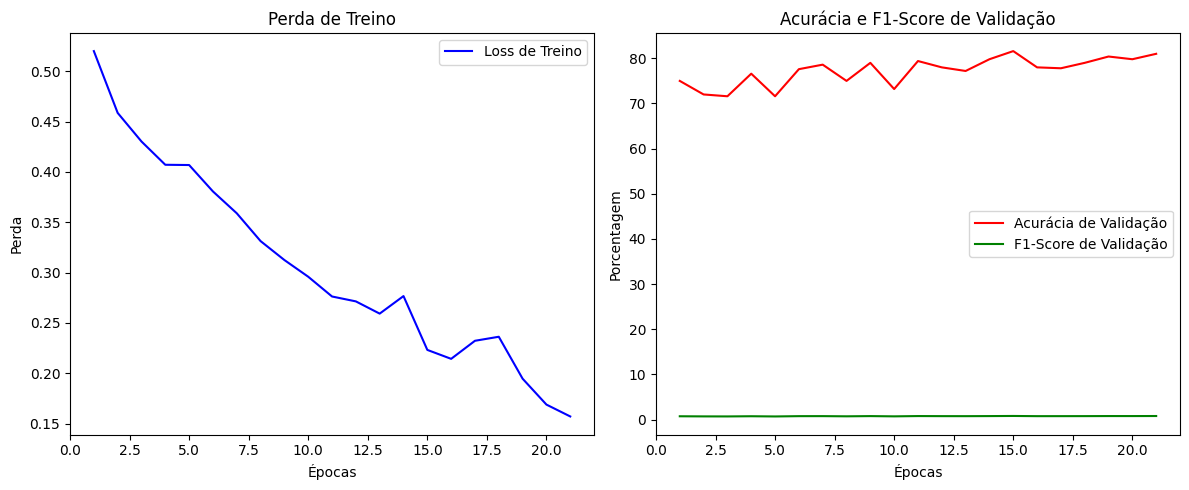

Testing model on test dataset...
Validation Accuracy: 80.60%, Macro F1-Score: 0.7985


In [4]:
import torch
import torchvision
import numpy as np
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset, Dataset
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Classe para manipulação dos dados e treinamento do modelo
class ImageClassifier:
    def __init__(self, num_classes, batch_size=32, lr=0.0001, epochs=21):
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.lr = lr
        self.epochs = epochs
        self.model = self.create_model()
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.class_mapping = None
        self.train_loader = None
        self.val_loader = None
        self.test_loader = None

    # Criação do modelo ResNet18
    def create_model(self):
        model = models.resnet18()
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(
            #nn.Dropout(0.5),
            nn.Linear(num_ftrs, self.num_classes)
        )
        return model.to(device)

    # Função para filtrar as classes desejadas
    @staticmethod
    def filter_classes(dataset, selected_classes):
        indices = [idx for idx, (_, label) in enumerate(dataset) if label in selected_classes]
        return Subset(dataset, indices)

    # Classe customizada para mapear os rótulos das classes
    class MappedDataset(Dataset):
        def __init__(self, subset, class_mapping):
            self.subset = subset
            self.class_mapping = class_mapping

        def __len__(self):
            return len(self.subset)

        def __getitem__(self, idx):
            img, label = self.subset[idx]
            label = self.class_mapping.get(label, -1)
            return img, label

    # Função para preparar os dados e criar DataLoader
    def prepare_data(self, data_transform, train_dataset, val_dataset, test_dataset, selected_classes):
        # Mapear classes para [0, 49]
        self.class_mapping = {original: new for new, original in enumerate(selected_classes)}

        # Filtragem e mapeamento dos datasets
        train_subset = self.filter_classes(train_dataset, selected_classes)
        val_subset = self.filter_classes(val_dataset, selected_classes)
        test_subset = self.filter_classes(test_dataset, selected_classes)

        train_mapped = self.MappedDataset(train_subset, self.class_mapping)
        val_mapped = self.MappedDataset(val_subset, self.class_mapping)
        test_mapped = self.MappedDataset(test_subset, self.class_mapping)

        # DataLoaders
        self.train_loader = DataLoader(train_mapped, batch_size=self.batch_size, shuffle=True)
        self.val_loader = DataLoader(val_mapped, batch_size=self.batch_size, shuffle=False)
        self.test_loader = DataLoader(test_mapped, batch_size=self.batch_size, shuffle=False)

    # Função de treino
    def train(self):
        print("Starting training...")
        train_losses = []
        val_accuracies = []
        val_f1_scores = []

        for epoch in range(self.epochs):
            self.model.train()
            running_loss = 0.0
            for inputs, labels in self.train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(self.train_loader.dataset)
            train_losses.append(epoch_loss)
            print(f'Epoch {epoch + 1}/{self.epochs}, Loss: {epoch_loss:.4f}')

            # Validação após cada época
            val_accuracy, val_f1 = self.validate(self.val_loader)
            val_accuracies.append(val_accuracy)
            val_f1_scores.append(val_f1)

        print("Training complete.")
        return train_losses, val_accuracies, val_f1_scores

    # Função de validação
    def validate(self, loader):
        self.model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []

        with torch.no_grad():
            for inputs, labels in loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

        accuracy = accuracy_score(all_labels, all_predictions) * 100
        f1 = f1_score(all_labels, all_predictions, average='macro')
        print(f'Validation Accuracy: {accuracy:.2f}%, Macro F1-Score: {f1:.4f}')
        return accuracy, f1

    # Função para testar o modelo com o conjunto de teste
    def test(self):
        print("Testing model on test dataset...")
        return self.validate(self.test_loader)

# Uso da classe ImageClassifier para treino, validação e teste

# Parâmetros
selected_classes = np.array([7, 18, 64, 14, 8, 47, 94, 84, 30, 74, 27, 70, 33, 1, 28, 95, 32,
                             72, 77, 60, 55, 79, 11, 54, 59, 29, 51, 43, 71, 5, 92, 53, 34,
                             2, 48, 36, 9, 39, 42, 15, 17, 86, 45, 93, 62, 49, 46, 82, 68, 21])

data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomAffine(degrees=30, shear=20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
def plot_curves(train_losses, val_accuracies, val_f1_scores):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot da curva de perda de treino
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Loss de Treino')
    plt.title('Perda de Treino')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    # Plot da curva de acurácia de validação
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, 'r', label='Acurácia de Validação')
    plt.plot(epochs, val_f1_scores, 'g', label='F1-Score de Validação')
    plt.title('Acurácia e F1-Score de Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Porcentagem')
    plt.legend()

    # Exibir os gráficos
    plt.tight_layout()
    plt.show()
# Carregamento dos datasets
train_dataset = datasets.Flowers102(root=r'E:\Dataset_torchvision', split='test', download=True, transform=data_transform)
val_dataset = datasets.Flowers102(root=r'E:\Dataset_torchvision', split='val', download=True, transform=data_transform)
test_dataset = datasets.Flowers102(root=r'E:\Dataset_torchvision', split='train', download=True, transform=data_transform)
num_classes=50
batch_size=32
lr=0.0001
epochs=21

# Inicializar a classe
classifier = ImageClassifier(num_classes=num_classes, batch_size=batch_size, lr=lr, epochs=epochs)
classifier.model.load_state_dict(torch.load(r"C:\Users\fabri\Desktop\UFES\ML\data" + os.sep + 'train_1_epoch_21_lr_0.0001_drop.pth', weights_only=True))
# Preparar os dados
classifier.prepare_data(data_transform, train_dataset, val_dataset, test_dataset, selected_classes)

# Treinamento e validação
train_losses, val_accuracies, val_f1_scores = classifier.train()
plot_curves(train_losses,val_accuracies,val_f1_scores)
# Teste do modelo no conjunto de teste
test_accuracy, test_f1 = classifier.test()
import os
modelo_criado = f'train_2_epoch_{epochs}_lr_{str(lr)}_drop.pth'
torch.save(classifier.model.state_dict(), r"C:\Users\fabri\Desktop\UFES\ML\data" + os.sep + modelo_criado)

Using device: cuda
Starting training...
Epoch 1/21, Loss: 0.2017
Validation Accuracy: 78.80%, Macro F1-Score: 0.7786
Epoch 2/21, Loss: 0.1699
Validation Accuracy: 80.60%, Macro F1-Score: 0.7987
Epoch 3/21, Loss: 0.1950
Validation Accuracy: 80.80%, Macro F1-Score: 0.8042
Epoch 4/21, Loss: 0.1722
Validation Accuracy: 78.00%, Macro F1-Score: 0.7662
Epoch 5/21, Loss: 0.1961
Validation Accuracy: 82.00%, Macro F1-Score: 0.8184
Epoch 6/21, Loss: 0.1617
Validation Accuracy: 83.40%, Macro F1-Score: 0.8291
Epoch 7/21, Loss: 0.1470
Validation Accuracy: 84.20%, Macro F1-Score: 0.8369
Epoch 8/21, Loss: 0.1448
Validation Accuracy: 82.80%, Macro F1-Score: 0.8249
Epoch 9/21, Loss: 0.1584
Validation Accuracy: 79.80%, Macro F1-Score: 0.7892
Epoch 10/21, Loss: 0.1263
Validation Accuracy: 84.20%, Macro F1-Score: 0.8386
Epoch 11/21, Loss: 0.1052
Validation Accuracy: 81.60%, Macro F1-Score: 0.8123
Epoch 12/21, Loss: 0.1116
Validation Accuracy: 82.20%, Macro F1-Score: 0.8149
Epoch 13/21, Loss: 0.1565
Validat

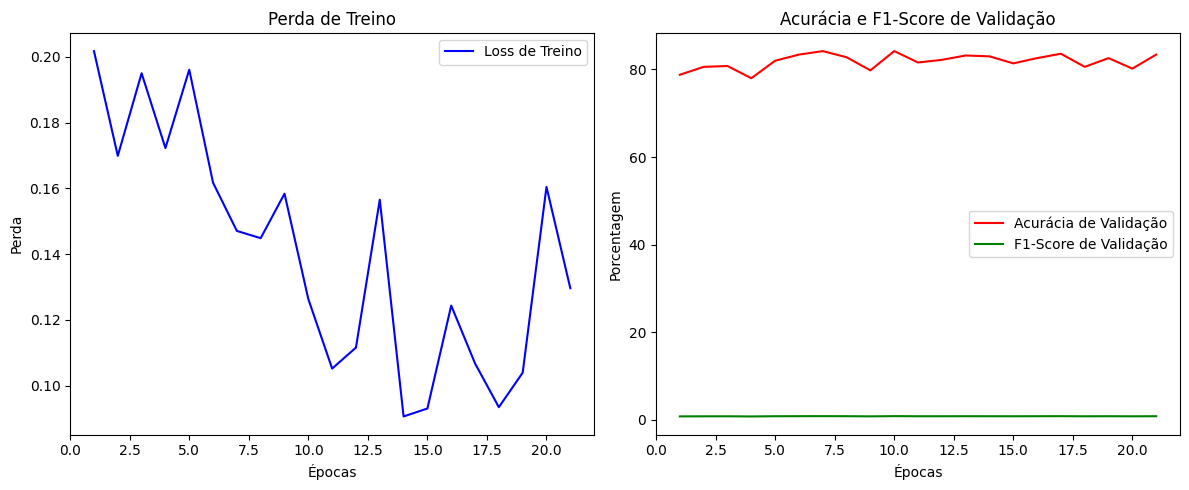

Testing model on test dataset...
Validation Accuracy: 80.00%, Macro F1-Score: 0.7922


In [5]:
import torch
import torchvision
import numpy as np
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset, Dataset
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import os
# Verificar se GPU está disponível
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Classe para manipulação dos dados e treinamento do modelo
class ImageClassifier:
    def __init__(self, num_classes, batch_size=32, lr=0.001, epochs=10):
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.lr = lr
        self.epochs = epochs
        self.model = self.create_model()
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.class_mapping = None
        self.train_loader = None
        self.val_loader = None
        self.test_loader = None

    # Criação do modelo ResNet18
    def create_model(self):
        model = models.resnet18()
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(
            #nn.Dropout(0.5),
            nn.Linear(num_ftrs, self.num_classes)
        )
        return model.to(device)

    # Função para filtrar as classes desejadas
    @staticmethod
    def filter_classes(dataset, selected_classes):
        indices = [idx for idx, (_, label) in enumerate(dataset) if label in selected_classes]
        return Subset(dataset, indices)

    # Classe customizada para mapear os rótulos das classes
    class MappedDataset(Dataset):
        def __init__(self, subset, class_mapping):
            self.subset = subset
            self.class_mapping = class_mapping

        def __len__(self):
            return len(self.subset)

        def __getitem__(self, idx):
            img, label = self.subset[idx]
            label = self.class_mapping.get(label, -1)
            return img, label

    # Função para preparar os dados e criar DataLoader
    def prepare_data(self, data_transform, train_dataset, val_dataset, test_dataset, selected_classes):
        # Mapear classes para [0, 49]
        self.class_mapping = {original: new for new, original in enumerate(selected_classes)}

        # Filtragem e mapeamento dos datasets
        train_subset = self.filter_classes(train_dataset, selected_classes)
        val_subset = self.filter_classes(val_dataset, selected_classes)
        test_subset = self.filter_classes(test_dataset, selected_classes)

        train_mapped = self.MappedDataset(train_subset, self.class_mapping)
        val_mapped = self.MappedDataset(val_subset, self.class_mapping)
        test_mapped = self.MappedDataset(test_subset, self.class_mapping)

        # DataLoaders
        self.train_loader = DataLoader(train_mapped, batch_size=self.batch_size, shuffle=True)
        self.val_loader = DataLoader(val_mapped, batch_size=self.batch_size, shuffle=False)
        self.test_loader = DataLoader(test_mapped, batch_size=self.batch_size, shuffle=False)

    # Função de treino
    def train(self):
        print("Starting training...")
        train_losses = []
        val_accuracies = []
        val_f1_scores = []

        for epoch in range(self.epochs):
            self.model.train()
            running_loss = 0.0
            for inputs, labels in self.train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(self.train_loader.dataset)
            train_losses.append(epoch_loss)
            print(f'Epoch {epoch + 1}/{self.epochs}, Loss: {epoch_loss:.4f}')

            # Validação após cada época
            val_accuracy, val_f1 = self.validate(self.val_loader)
            val_accuracies.append(val_accuracy)
            val_f1_scores.append(val_f1)

        print("Training complete.")
        return train_losses, val_accuracies, val_f1_scores

    # Função de validação
    def validate(self, loader):
        self.model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []

        with torch.no_grad():
            for inputs, labels in loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

        accuracy = accuracy_score(all_labels, all_predictions) * 100
        f1 = f1_score(all_labels, all_predictions, average='macro')
        print(f'Validation Accuracy: {accuracy:.2f}%, Macro F1-Score: {f1:.4f}')
        return accuracy, f1

    # Função para testar o modelo com o conjunto de teste
    def test(self):
        print("Testing model on test dataset...")
        return self.validate(self.test_loader)

# Uso da classe ImageClassifier para treino, validação e teste

# Parâmetros
selected_classes = np.array([7, 18, 64, 14, 8, 47, 94, 84, 30, 74, 27, 70, 33, 1, 28, 95, 32,
                             72, 77, 60, 55, 79, 11, 54, 59, 29, 51, 43, 71, 5, 92, 53, 34,
                             2, 48, 36, 9, 39, 42, 15, 17, 86, 45, 93, 62, 49, 46, 82, 68, 21])

data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomAffine(degrees=30, shear=20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
def plot_curves(train_losses, val_accuracies, val_f1_scores):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot da curva de perda de treino
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Loss de Treino')
    plt.title('Perda de Treino')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    # Plot da curva de acurácia de validação
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, 'r', label='Acurácia de Validação')
    plt.plot(epochs, val_f1_scores, 'g', label='F1-Score de Validação')
    plt.title('Acurácia e F1-Score de Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Porcentagem')
    plt.legend()

    # Exibir os gráficos
    plt.tight_layout()
    plt.show()
# Carregamento dos datasets
train_dataset = datasets.Flowers102(root=r'E:\Dataset_torchvision', split='test', download=True, transform=data_transform)
val_dataset = datasets.Flowers102(root=r'E:\Dataset_torchvision', split='val', download=True, transform=data_transform)
test_dataset = datasets.Flowers102(root=r'E:\Dataset_torchvision', split='train', download=True, transform=data_transform)
num_classes=50
batch_size=32
lr=0.0001
epochs=21

# Inicializar a classe
classifier = ImageClassifier(num_classes=num_classes, batch_size=batch_size, lr=lr, epochs=epochs)
classifier.model.load_state_dict(torch.load(r"C:\Users\fabri\Desktop\UFES\ML\data" + os.sep + 'train_2_epoch_21_lr_0.0001_drop.pth', weights_only=True))
# Preparar os dados
classifier.prepare_data(data_transform, train_dataset, val_dataset, test_dataset, selected_classes)
# Treinamento e validação
train_losses, val_accuracies, val_f1_scores = classifier.train()

plot_curves(train_losses,val_accuracies,val_f1_scores)
# Teste do modelo no conjunto de teste
test_accuracy, test_f1 = classifier.test()
import os
modelo_criado = f'train_3_epoch_{epochs}_lr_{str(lr)}_drop.pth'
torch.save(classifier.model.state_dict(), r"C:\Users\fabri\Desktop\UFES\ML\data" + os.sep + modelo_criado)